<a href="https://colab.research.google.com/github/PPierzc/PracowniaEEG/blob/master/Widmowa_analiza_parametryczna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

! rm -rf PracowniaEEG
! git clone https://github.com/PPierzc/PracowniaEEG.git
  
import PracowniaEEG.filters as filters
import PracowniaEEG.cw4_utils as utils
import PracowniaEEG.mtmvar as mtmvar

! pip install wget
import wget

!pip install obci_readmanager
from obci_readmanager.signal_processing.read_manager import ReadManager

import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


import scipy


sns.set()
sns.set_context("talk", font_scale=1.4)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Cloning into 'PracowniaEEG'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 188 (delta 15), reused 0 (delta 0), pack-reused 157
Receiving objects: 100% (188/188), 74.96 MiB | 15.13 MiB/s, done.
Resolving deltas: 100% (92/92), done.


# Zadanie 1

In [31]:
filename = "gdrive/My Drive/pracowniaEEG/cw1/zamkniete"
mgr = ReadManager("%s.xml"%filename, "%s.raw"%filename, "%s.tag"%filename)
fs = int(float(mgr.get_param("sampling_frequency")))
num_of_channels = int(mgr.get_param("number_of_channels"))
channels_names = mgr.get_param("channels_names")

raw_syg_open = mgr.get_microvolt_samples()
t = np.arange(raw_syg_open.shape[1])/fs

choosen_channel = "O2"
s = raw_syg_open[channels_names.index(choosen_channel),:]
del(raw_syg_open)

s = filters.butter_highpass_filter(s, 1, fs, order=5)
s = filters.notch_filter(s, 50, fs)

syg = s[len(s)//2 : len(s)//2 + 1000]
syg = syg.reshape(1, syg.size)

x = np.arange(syg.size)
x = x.reshape(1, x.size)
s = s.reshape(1, s.size)

2019-01-24 13:41:46,930 - data_source - INFO - All data set requested for the first time. Start reading all data from the file...


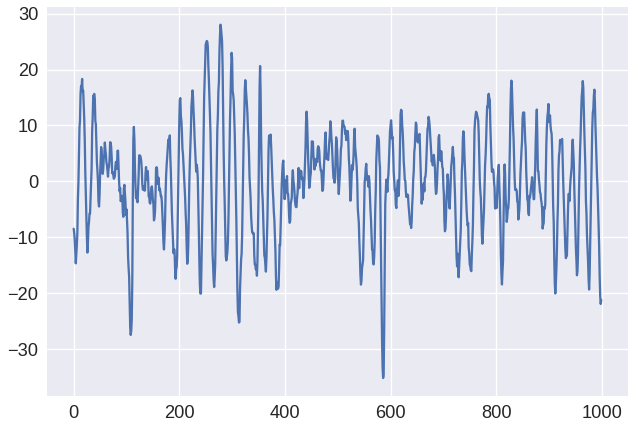

In [6]:
plt.figure()
plt.plot(x[0],syg[0])
plt.show()
plt.close()

1 [[[0.95027516]]]
2 [[[ 1.64314059]]

 [[-0.72912084]]]
3 [[[ 1.52986837]]

 [[-0.47385152]]

 [[-0.15535452]]]
4 [[[ 1.52141162]]

 [[-0.4996457 ]]

 [[-0.07207591]]

 [[-0.05443515]]]
5 [[[ 1.52168735]]

 [[-0.49928062]]

 [[-0.06954509]]

 [[-0.06214146]]

 [[ 0.00506524]]]


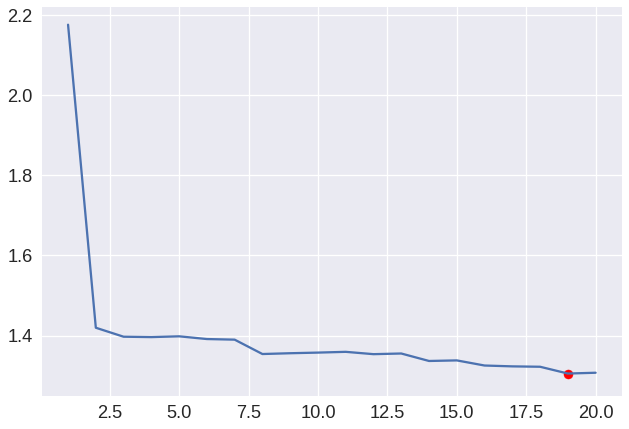

In [7]:
AIC = utils.coeffs(syg, 1, 5)
for _x in AIC:
  print(len(_x[0]), _x[0])
  
AIC = utils.get_aic_func(syg, 1, 20)
order, params, coefs = utils.best_akaike(syg, 1, 20)

plt.figure()
plt.plot(list(range(1, 21)), AIC)
plt.scatter(order, np.log(np.linalg.det(coefs)) + 2 * order * syg.shape[0] * \
            syg.shape[0] / syg.shape[1], color='r')
plt.show()
plt.close()



#Zadanie 2

In [0]:
def widmo(s, order, f_max, Fs=128,df=1):
  efs = np.arange(0, f_max+1, df)

  k = np.shape(s)[0]
  
  widma = np.empty((efs.size, k, k), dtype="complex")
  
  coef, V = mtmvar.mult_AR(s, order, 1)
  coef *= -1
  
  for j, f in enumerate(efs):
    A = np.eye(k, dtype='complex')
  
    for i in range(len(coef)):
        A += coef[i,:,:] * np.exp(2 * 1j * np.pi * f / Fs)**(-i - 1)

    H = np.linalg.inv(A)
    
    w = np.dot(np.dot(H,V), np.conjugate(H.T))
    
    widma[j] = w
    
  return efs, widma
  
  

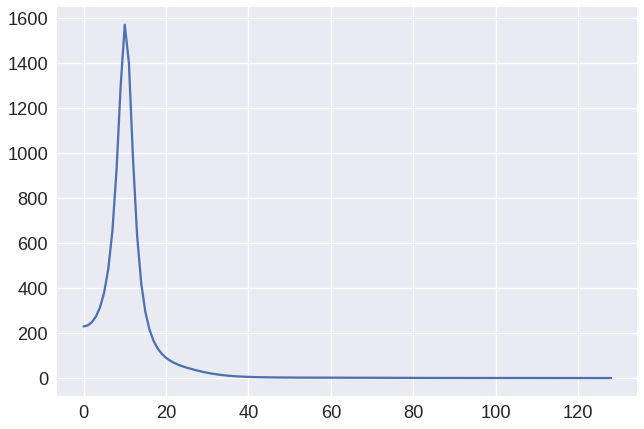

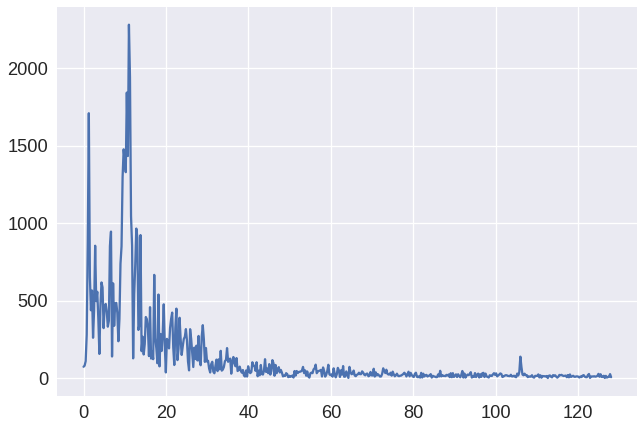

In [36]:
xf, S = widmo(syg, order, 128, fs)
plt.figure()
plt.plot(xf, abs(S[:, 0]))
plt.show()
plt.close()


plt.figure()
S = np.fft.rfft(syg)
freq = np.fft.rfftfreq(syg.size, d=1./fs)
plt.plot(freq, abs(S[0,:]))
plt.show()
plt.close()

#Zadanie 3

In [0]:
def coherence(widmo, i, j):
  return widmo[:, i, j] / (widmo[:, i, i] * widmo[:, j, j])**.5

def sin(f=32,N=1000,Fs=128,phi=0):
	dt = 1.0/Fs
  
	x = np.arange(0,N/Fs,dt)
	g = np.sin(2*np.pi*f*x + phi)
	return x, g

def noise(N):
  return np.random.uniform(-1,1, N)

2


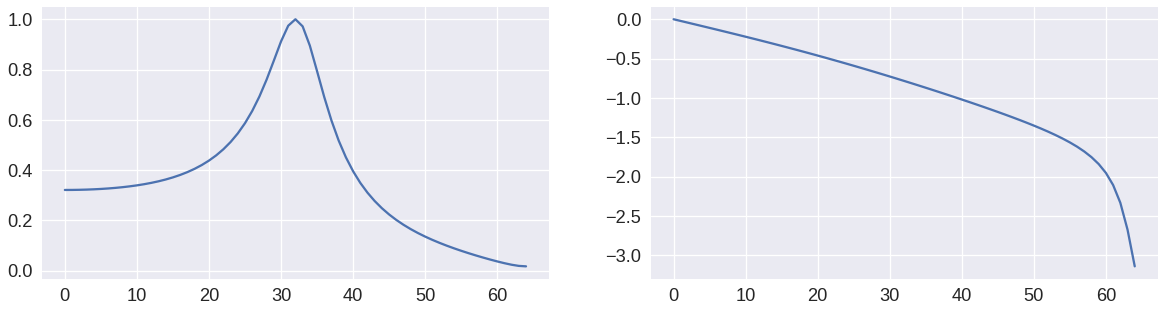

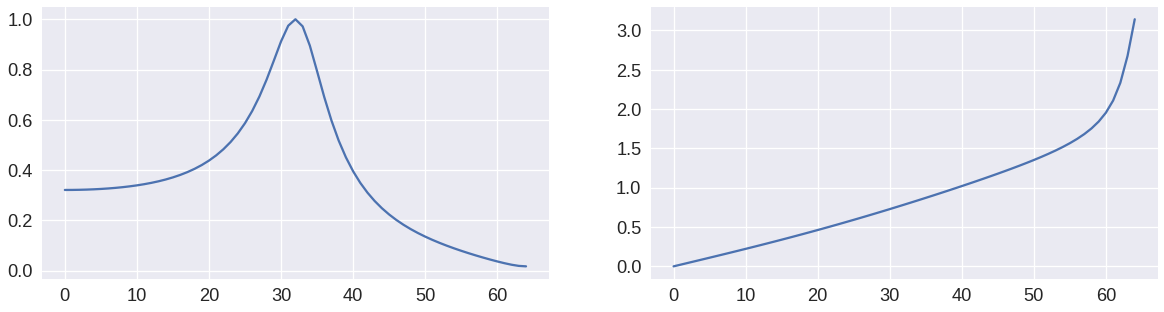

1 [[[0.95091134]]]
2 [[[ 1.61743029]]

 [[-0.7009265 ]]]
3 [[[ 1.52411197]]

 [[-0.48558882]]

 [[-0.13313568]]]
4 [[[ 1.50741367]]

 [[-0.54649289]]

 [[ 0.05802322]]

 [[-0.12542314]]]
5 [[[ 1.5122016 ]]

 [[-0.54870788]]

 [[ 0.07888512]]

 [[-0.18296737]]

 [[ 0.03817415]]]


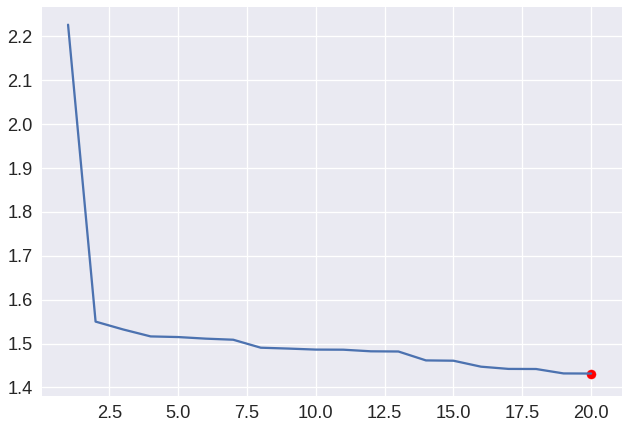

In [50]:

x, g1 = sin()
x, g2 = sin(phi = np.pi/4)

g2 += noise(g2.size) * 0.2

syg = np.array([g1,g2])

order, params, coefs = utils.best_akaike(syg, 1, 20)
print(order)

efs, widma = widmo(syg, order, 128//2, Fs=128)

plt.figure(figsize=(20, 5))
coh = coherence(widma, 0, 1)

plt.subplot(1, 2, 1)
plt.plot(efs, abs(coh))


plt.subplot(1, 2, 2)
plt.plot(efs, np.angle(coh))

plt.show()

plt.figure(figsize=(20, 5))
coh = coherence(widma, 1, 0)
plt.subplot(1, 2, 1)
plt.plot(efs, abs(coh))


plt.subplot(1, 2, 2)
plt.plot(efs, np.angle(coh))

plt.show()

AIC = utils.coeffs(s, 1, 5)
for _x in AIC:
  print(len(_x[0]), _x[0])
  
AIC = utils.get_aic_func(s, 1, 20)
order, params, coefs = utils.best_akaike(s, 1, 20)

plt.figure()
plt.plot(list(range(1, 21)), AIC)
plt.scatter(order, np.log(np.linalg.det(coefs)) + 2 * order * s.shape[0] * \
            s.shape[0] / s.shape[1], color='r')
plt.show()
plt.close()

In [0]:
?np.random.random

# Zadanie 4

/usr/local/lib/python3.6/dist-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


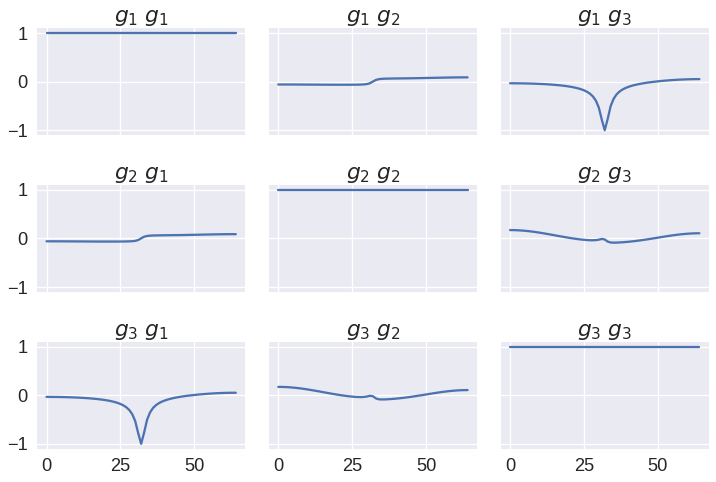

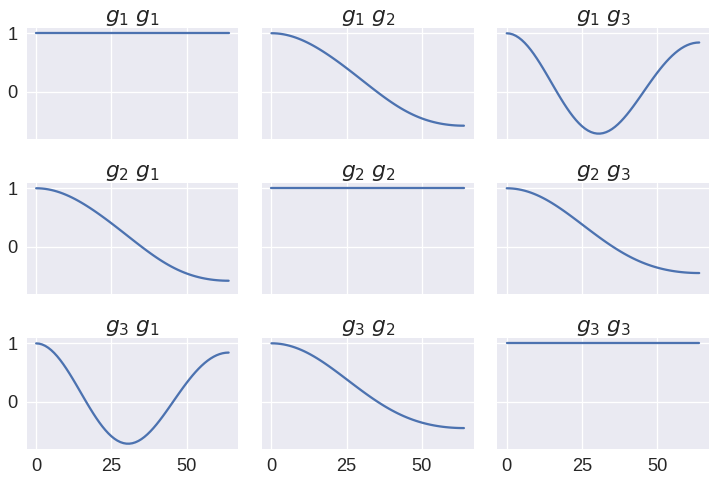

In [54]:
x, g = sin(f=32,N=1002,Fs=128,phi=0)
x, g1 = x[2:], g[2:]
g2 = 0.4 * np.copy(g[1:-1]) + noise(g1.size) * 0.2
g3 = 0.3 * np.copy(g[0:-2]) + noise(g1.size) * 0.2


syg = np.array([g1,g2,g3])

order, params, coefs = utils.best_akaike(syg, 1, 20)
efs, widma = widmo(syg, order, 128//2, Fs=128)


fig, ax = plt.subplots(nrows=3, ncols=3, sharex=True,sharey=True)

for i, row in enumerate(ax):
    for j, col in enumerate(row):
        coh = coherence(widma, i, j)
        col.plot(efs, coh)
        col.set_title('$g_%s$ $g_%s$'%(i+1,j+1))
    
fig.tight_layout()
fig.show()









x = np.arange(fs + 2)/fs
g = np.copy(s[0, s.size//2 : s.size//2 + 1002])
x, g1 = x[2:], g[2:]
g2 = 0.4 * g[1:-1] + noise(g1.size) * 0.2
g3 = 0.3 * g[0:-2] + noise(g1.size) * 0.2

syg = np.array([g1,g2,g3])

order, params, coefs = utils.best_akaike(syg, 1, 5)
efs, widma = widmo(syg, order, 128//2, Fs=128)


fig, ax = plt.subplots(nrows=3, ncols=3, sharex=True,sharey=True)

for i, row in enumerate(ax):
    for j, col in enumerate(row):
        coh = coherence(widma, i, j)
        col.plot(efs, coh)
        col.set_title('$g_%s$ $g_%s$'%(i+1,j+1))
        
    
fig.tight_layout()
fig.show()





# Zadanie 5


In [0]:
s.shape

In [0]:
plt.plot(s[0])

In [0]:
s[0,:10]

In [0]:
!cd content

In [15]:
dupa.shape

(1002,)